/home/takayuki/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Epoch 0, Loss: 0.3408
Epoch 100, Loss: 0.0068
Epoch 200, Loss: 0.0011
Epoch 300, Loss: 0.0005
Epoch 400, Loss: 0.0004


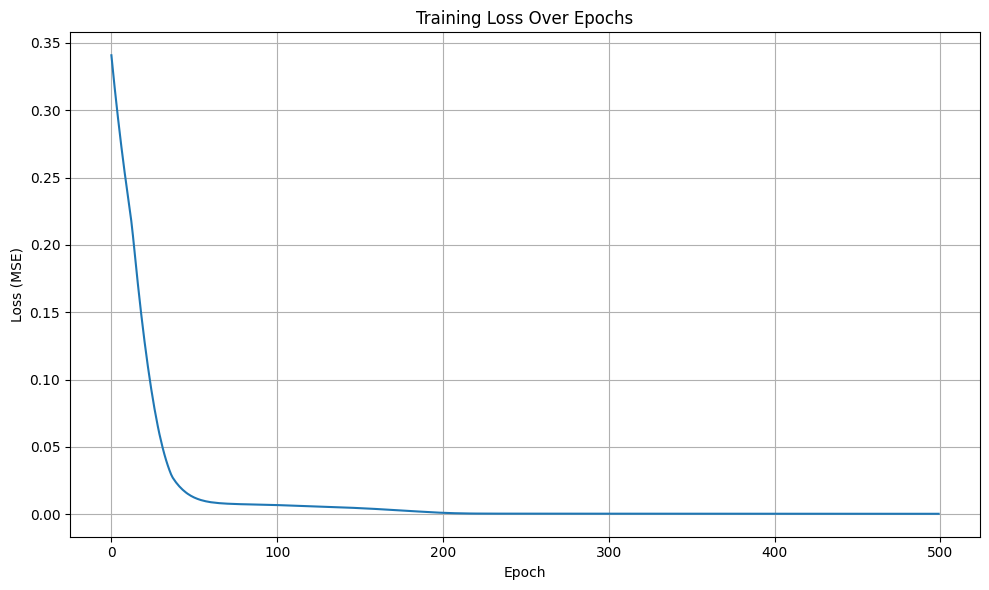

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load and preprocess the dataset
df = pd.read_csv("./data/gas.csv")
df = df.dropna()
y = df['Price'].values
x = np.arange(len(y))

# Normalize the output (Price)
minm, maxm = y.min(), y.max()
y = (y - minm) / (maxm - minm)

# Create sequences: X = y[i to i+10], Y = y[i+11]
Sequence_Length = 10
X, Y = [], []
for i in range(len(y) - Sequence_Length - 1):
    X.append(y[i:i + Sequence_Length])
    Y.append(y[i + Sequence_Length])
X = np.array(X)
Y = np.array(Y)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, shuffle=False)

# Custom PyTorch Dataset
class NGTimeSeries(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = NGTimeSeries(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# Define RNN Model
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=5, num_layers=1, batch_first=True)
        self.fc = nn.Linear(5, 1)
    
    def forward(self, x):
        output, _ = self.rnn(x)
        out = output[:, -1, :] # last time step
        return self.fc(torch.relu(out)).squeeze()

# Model, loss, optimizer
model = RNNModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Lists to store loss values for plotting
train_losses = []

# Training Loop
epochs = 500
for epoch in range(epochs):
    epoch_losses = []
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        preds = model(batch_x)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    
    # Store average loss for this epoch
    avg_loss = np.mean(epoch_losses)
    train_losses.append(avg_loss)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.tight_layout()
plt.show()


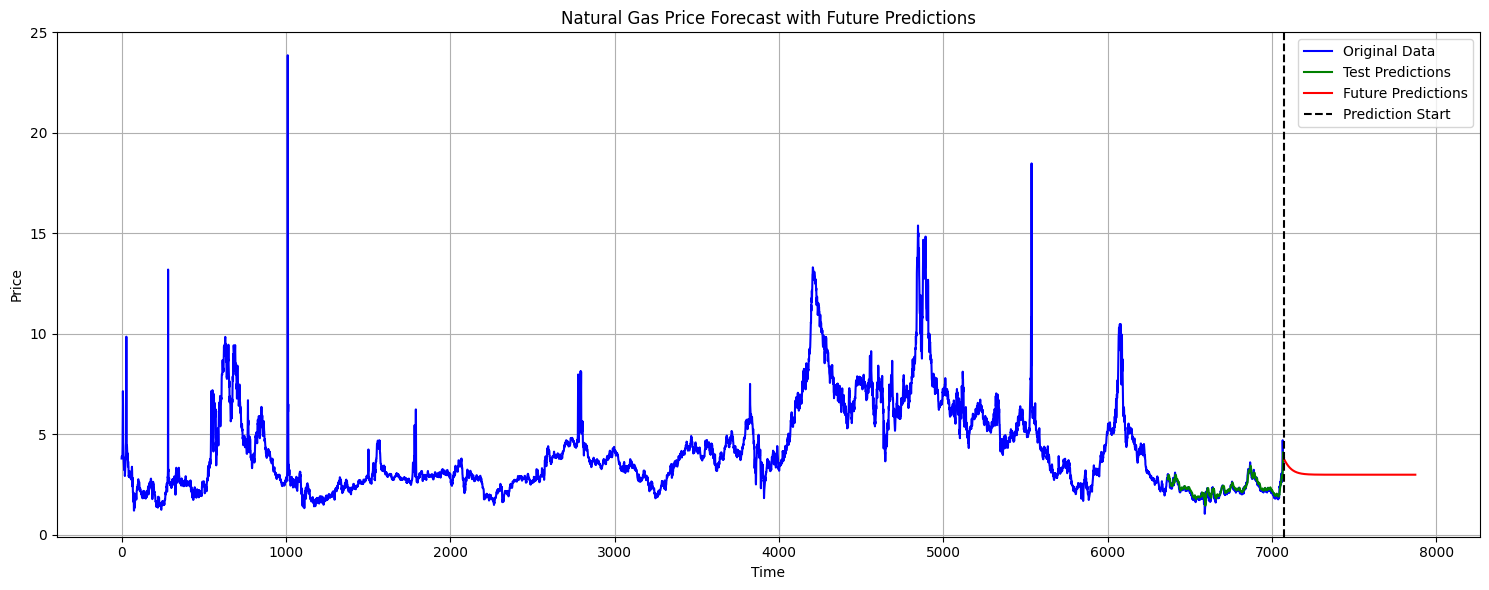

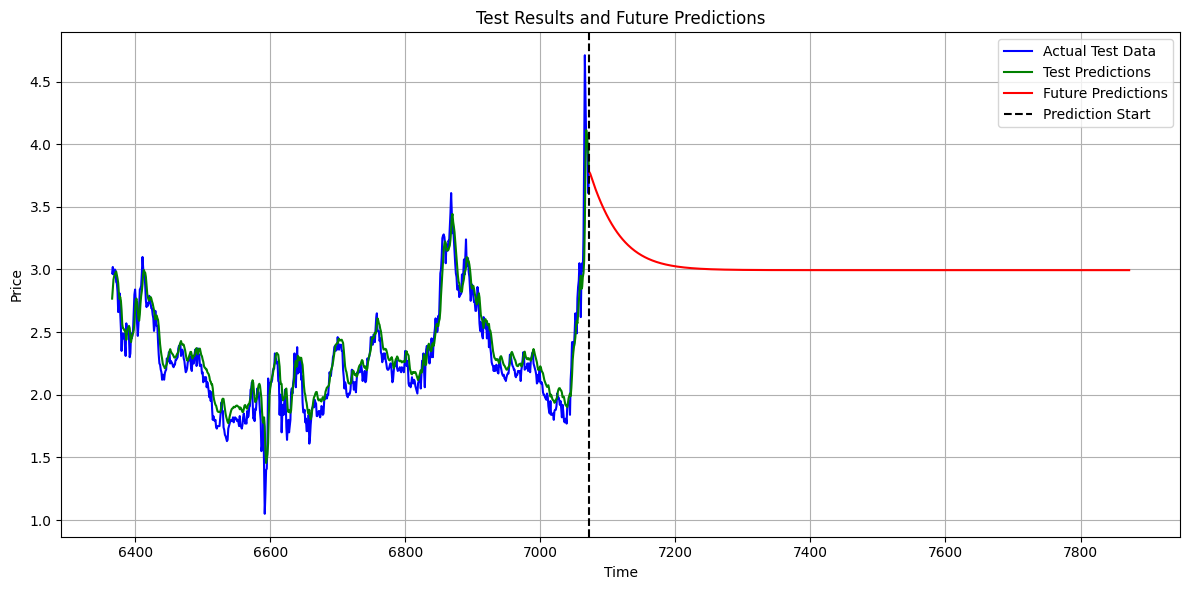

In [2]:

# Evaluation on test data
test_dataset = NGTimeSeries(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
test_x, test_y = next(iter(test_loader))
pred_y = model(test_x).detach().numpy()

# De-normalize test predictions
actual_y = test_y.numpy() * (maxm - minm) + minm
pred_y = pred_y * (maxm - minm) + minm

# Now generate future predictions for 100 additional steps
predict_eps = 800
future_preds = []

# Get the last sequence from the test data
last_seq = y[-Sequence_Length:].reshape(1, -1)
last_seq_tensor = torch.tensor(last_seq, dtype=torch.float32).unsqueeze(-1)

# Generate predictions one by one
model.eval()
with torch.no_grad():
    curr_seq = last_seq_tensor
    for _ in range(predict_eps):
        # Get prediction for next step
        next_pred = model(curr_seq).item()
        future_preds.append(next_pred)
        
        # Update sequence for next prediction
        curr_seq = torch.cat([curr_seq[:, 1:, :], 
                             torch.tensor([[[next_pred]]], dtype=torch.float32)], dim=1)

# De-normalize future predictions
future_preds_denorm = np.array(future_preds) * (maxm - minm) + minm

# Create x-axis indices for plotting
test_indices = np.arange(len(y) - len(pred_y), len(y))
future_indices = np.arange(len(y), len(y) + predict_eps)

# Plot predictions
plt.figure(figsize=(15, 6))
plt.plot(x, y * (maxm - minm) + minm, label="Original Data", color='blue')
plt.plot(test_indices, pred_y, label="Test Predictions", color='green')
plt.plot(future_indices, future_preds_denorm, label="Future Predictions", color='red')
plt.axvline(x=len(y) - 1, color='black', linestyle='--', label="Prediction Start")
plt.title("Natural Gas Price Forecast with Future Predictions")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Also plot the forecasting results separately for clearer view
plt.figure(figsize=(12, 6))
plt.plot(test_indices, actual_y, label="Actual Test Data", color='blue')
plt.plot(test_indices, pred_y, label="Test Predictions", color='green')
plt.plot(future_indices, future_preds_denorm, label="Future Predictions", color='red')
plt.axvline(x=len(y) - 1, color='black', linestyle='--', label="Prediction Start")
plt.title("Test Results and Future Predictions")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()